In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.callbacks import TensorBoard
from keras import backend as K

In [2]:
original_dim = 100 * 100
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [3]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [6]:
from google.colab import drive

drive.mount('/content/drive')
!cp "/content/drive/MyDrive/UTKFace.tar.gz" .
!tar xvzf UTKFace.tar.gz &> /dev/null
from tensorflow.keras import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import tensorboard
import os

dot = '.'
underline = '_'
# White =  "White"
# Black  = "Black" 
# Asian  = "Asian" 
# Indian = "Indian" 
# Others = "Others"

image = 'image'
Race  = 'Race'

img_path = list()
Races = list()

path = "/content/UTKFace"


for img in os.listdir(path):
  temp = img.split(dot)

  if len(temp[0].split(underline)) != 4:
    continue
  img_path.append(os.path.join(path, img))
  age, gender, race, date = temp[0].split(underline)
  Races.append(int(race))

# classLabels = {0:White, 1:Black, 2:Asian, 3:Indian, 4:Others}

Races = [str(utils.to_categorical(i, 5)) for i in Races]

df = pd.DataFrame({
    image : img_path,
    Race : Races
})

# TARGET_NAMES = df.Race.unique().tolist()


dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    validation_split = 0.3
)

height = 100
width = 100
BATCHSIZE = 32
TrainData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = image,
    y_col = Race,
    target_size = (height, width),
    color_mode = "grayscale",
    batch_size = BATCHSIZE,
    class_mode = 'categorical',
    subset = "training",
    shuffle = True
)

TestData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = image,
    y_col = Race,
    target_size = (height, width),
    color_mode = "grayscale",
    batch_size = BATCHSIZE,
    class_mode = 'categorical',
    subset = "validation",
    shuffle = True
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 16594 validated image filenames belonging to 5 classes.
Found 7111 validated image filenames belonging to 5 classes.


In [7]:
x_train, y_train = TrainData.next()
x_test, y_test = TestData.next()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 6931.4082 - val_loss: 6922.6514
Epoch 2/20
1/1 [==============================] - 0s 60ms/step - loss: 6923.3765 - val_loss: 6913.2266
Epoch 3/20
1/1 [==============================] - 0s 48ms/step - loss: 6913.3496 - val_loss: 6899.7061
Epoch 4/20
1/1 [==============================] - 0s 51ms/step - loss: 6900.7637 - val_loss: 6887.2471
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 6887.2896 - val_loss: 6870.5674
Epoch 6/20
1/1 [==============================] - 0s 50ms/step - loss: 6868.6279 - val_loss: 6847.8906
Epoch 7/20
1/1 [==============================] - 0s 48ms/step - loss: 6843.7852 - val_loss: 6826.4868
Epoch 8/20
1/1 [==============================] - 0s 51ms/step - loss: 6829.0723 - val_loss: 6778.3560
Epoch 9/20
1/1 [==============================] - 0s 66ms/step - loss: 6795.8594 - val_loss: 6753.5605
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 6

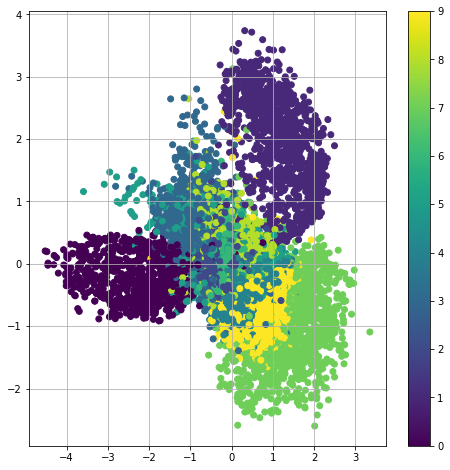

In [ ]:
batch_size = 32
x_test_encoded = encoder.predict(x_test, batch_size=8)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(8, 8))
xPlot = x_test_encoded[:, :, 0].flatten()
yPlot = x_test_encoded[:, :, 1].flatten()
plt.scatter(xPlot[:10000], yPlot[:10000], c=y_test)
plt.colorbar()
plt.grid(True)
plt.show()